# 1. Data preparation and basic analysis

In [1]:
#Load packages
library(dplyr)
library(tidytext)
library(lubridate)
library(tm)
library(tidyverse)
library(stringr)
library(ggplot2)
library(wordcloud)
library(RColorBrewer)
library(readr)
library(tidyr)
library(igraph)
library(ggraph)
library(widyr)
library(topicmodels)
library(Matrix)
library(janeaustenr)
library(scales)
library(magrittr)
library(Matrix)
library(textstem)
library(DT)
library(tools)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: NLP
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v readr   1.1.1
v tibble  1.4.1     v purrr   0.2.4
v tidyr   0.7.2     v stringr 1.2.0
v ggplot2 2.2.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x ggplot2::annotate()      masks NLP::annotate()
x lubridate::as.difftime() masks base::as.difftime()
x lubridate::date()        masks base::date()
x dplyr::filter()          masks stats::filter()
x lubridate::intersect()   masks base::intersect()
x dplyr::lag()             masks stats::lag()
x lubridate::setdiff()     masks base::setdiff()
x lubridate::union()       

In [2]:
# Set theme
theme_set(theme_minimal())

In [3]:
#Load data on food waste patents
df <- read.csv("ad1.csv")

In [4]:
# Keep text only
df <- as.character(df$text)

In [5]:
# Clean up text
df <- removeNumbers(df) #remove the numbers from the text
df <- removePunctuation(df) # remove the punctuation

### Tokenize text and remove stop words

In [6]:
# Converting text vector into a dataframe
text_df <- data_frame(line = 1:length(df), text = df)

In [7]:
#Tokenize
tokenized <- text_df %>%
    unnest_tokens(word, text)

In [8]:
#Remove common stop words
data("stop_words")

# Custom stop words
additional_stop_words <- data_frame(word=c("figref", "idrefdrawingsfig", "bb", "xb", "patent", "document", 
                                           "xbsubsub", "fig"， "invention"),
                                   lexicon = rep("custom"))

#Bind stop word data
all_stops <- bind_rows(stop_words, additional_stop_words)

# Remove stops
clean_text_df <- tokenized %>% 
    anti_join(all_stops)

Joining, by = "word"


### Basic word count visualization

In [9]:
# Get count of top words
clean_text_df_count <- clean_text_df %>% 
    count(word, sort = TRUE)  %>% 
    filter(n > 2000)  %>% 
    mutate(word = reorder(word, n)) %>% 
    ggplot(aes(word,n)) +
    geom_col() +
    xlab(NULL) +
    coord_flip()
# clean_text_df_count

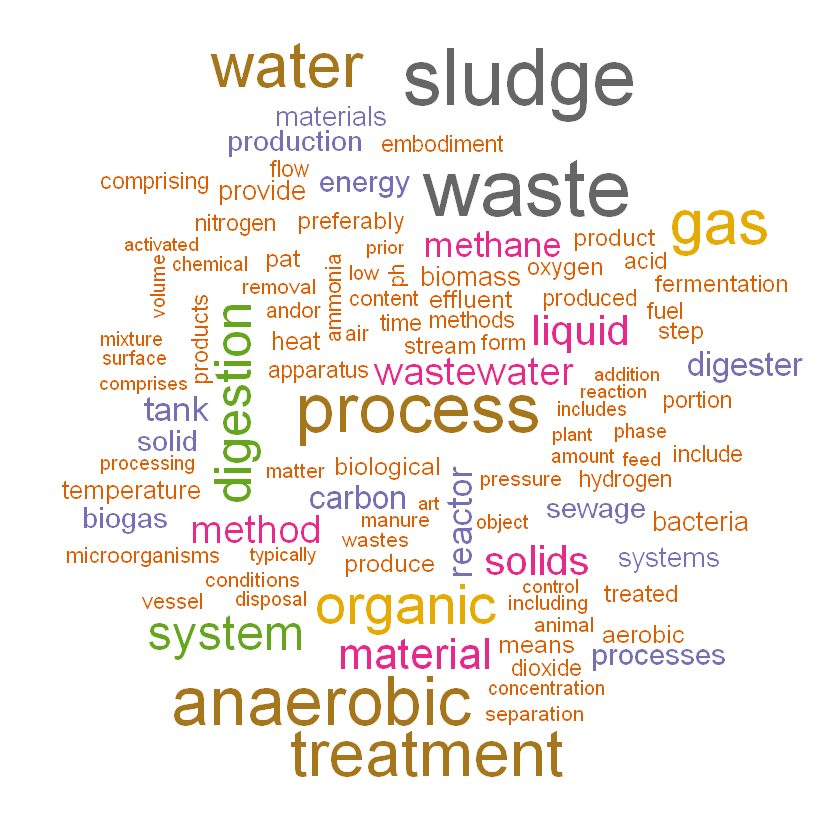

In [10]:
# Show wordcloud of top words
set.seed(0)
clean_text_df %>%
    count(word) %>%
    with(wordcloud(word, n, max.words = 100, colors=brewer.pal(8, "Dark2")))

# 2. TF-IDF

In [11]:
# Import data
df_with_patent_id <- read.csv("ad1.csv", stringsAsFactors = F)

In [12]:
df_with_patent_id$country <- NULL
df_with_patent_id$title <- NULL
df_with_patent_id$abstract <- NULL

In [13]:
df_with_patent_id$Abstract <- df_with_patent_id$text
df_with_patent_id$text <- NULL

In [14]:
df_with_patent_id$Abstract <- as.character(df_with_patent_id$Abstract)  %>% 
    removeNumbers() %>% 
    removePunctuation()

In [15]:
a <- mdy(df_with_patent_id$IssueDate)
df_with_patent_id$IssueDate  <- as.factor(year(a))
# head(df_with_patent_id, n=20)

df_with_patent_id$PatentNo  <- NULL
# df_with_patent_id

In [16]:
abstract_words <- df_with_patent_id %>% 
    unnest_tokens(word, Abstract)  %>% 
    anti_join(all_stops) %>% 
    count(IssueDate, word, sort=TRUE) %>% 
    ungroup()

total_words <- abstract_words %>% 
    group_by(IssueDate) %>% 
    summarize(total = sum(n))

Joining, by = "word"


In [17]:
abstract_words <- left_join(abstract_words, total_words)
# abstract_words

Joining, by = "IssueDate"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 197 rows containing non-finite values (stat_bin)."

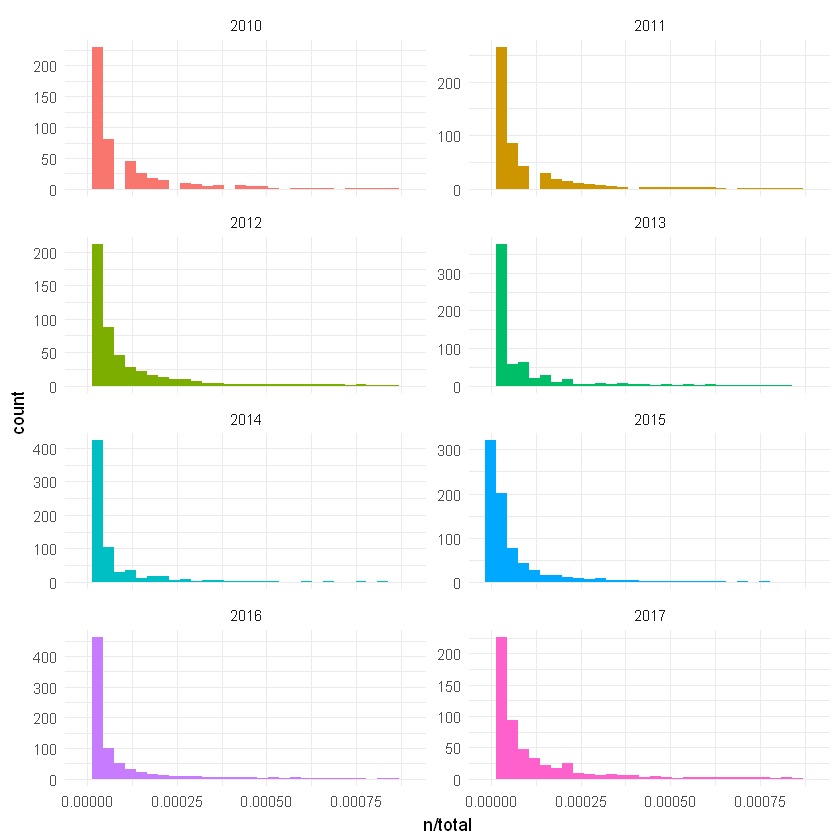

In [18]:
ggplot(subset(abstract_words, IssueDate == c("2010", "2011", "2012", "2013", "2014","2015","2016","2017","2018"), select=c(IssueDate:total)), 
       aes(n/total, fill = IssueDate)) +
  geom_histogram(show.legend = FALSE) +
  xlim(NA, 0.0009) +
  facet_wrap(~IssueDate, ncol = 2, scales = "free_y")

In [19]:
total_words <- df_with_patent_id %>% 
    count(IssueDate, sort=TRUE) 
# total_words

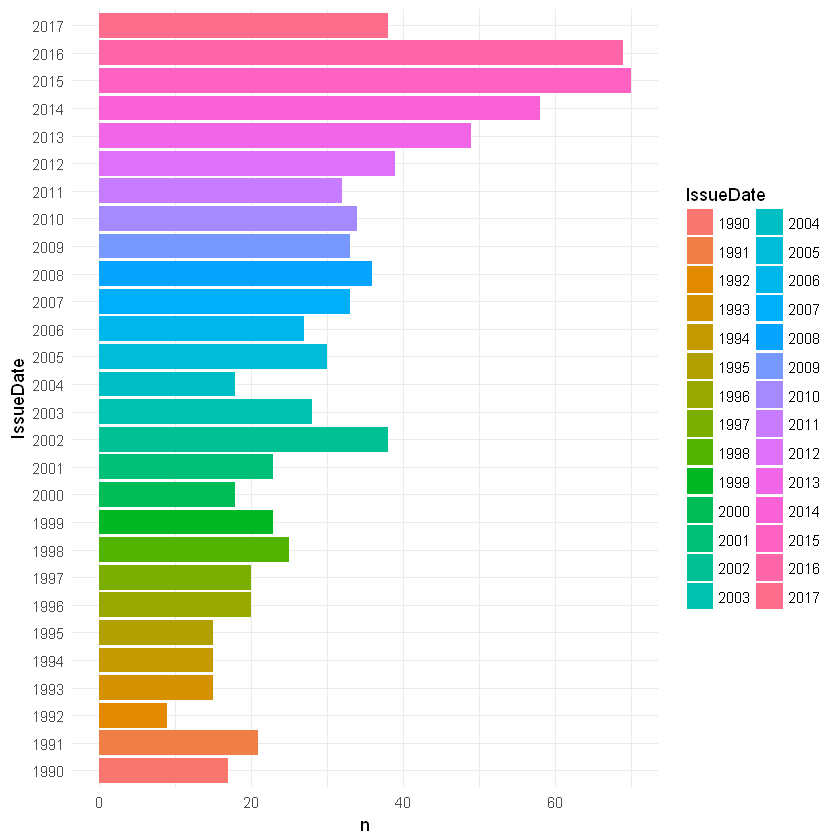

In [20]:
ggplot(data=subset(total_words, IssueDate %in% c("1990":"2018"))) +
    geom_col(aes(IssueDate, n, fill=IssueDate)) +
    coord_flip()

In [21]:
freq_by_rank <- abstract_words %>%
  group_by(IssueDate) %>%
  mutate(rank = row_number(),
         `term frequency` = n/total)

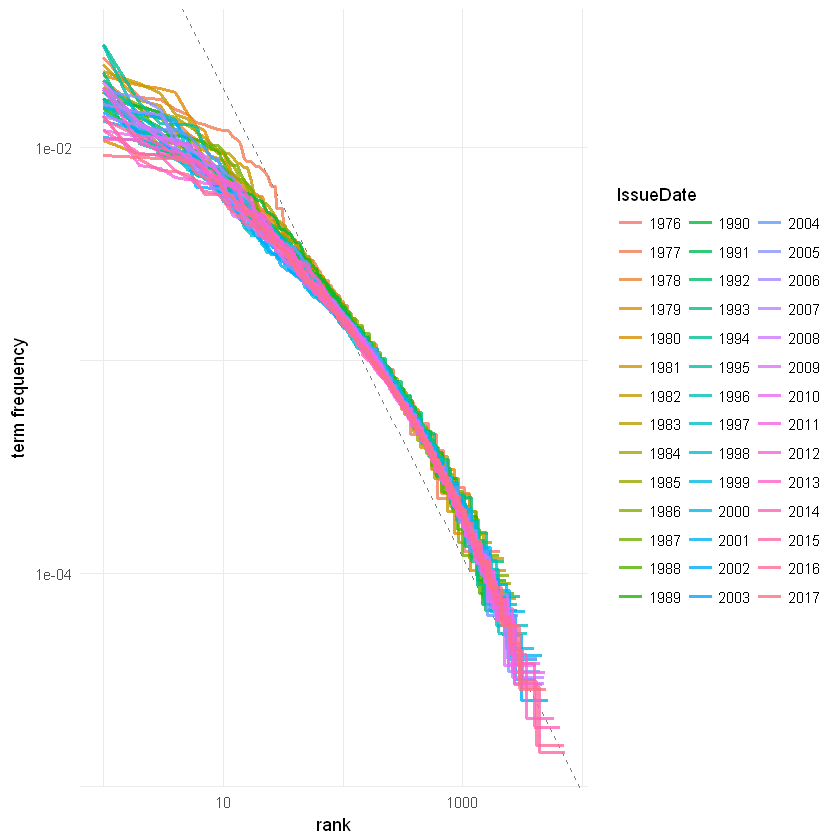

In [22]:
freq_by_rank %>%
  ggplot(aes(rank, `term frequency`, color = IssueDate)) +
  geom_abline(intercept = -0.62, slope = -1.1, color = "gray50", linetype = 2) +
  geom_line(size = 1.1, alpha = 0.8, show.legend = TRUE) +
  scale_x_log10() +
  scale_y_log10()

### TF-IDF on unigrams

In [23]:
abstract_tf_idf <- abstract_words %>% 
  bind_tf_idf(word, IssueDate,n)

In [24]:
abstract_tf_idf %>% 
  select(-total) %>% 
  arrange(desc(tf_idf))

IssueDate,word,n,tf,idf,tf_idf
1980,bactericidal,38,0.004475854,3.737670,0.016729263
1990,alicyclic,85,0.006067528,2.639057,0.016012554
1986,rank,53,0.005174265,3.044522,0.015753167
1982,downcomer,44,0.004304441,3.044522,0.013104968
1979,pressurised,38,0.005859676,2.128232,0.012470749
1992,stackpipe,51,0.005810641,2.128232,0.012366391
2015,orc,239,0.003471466,3.044522,0.010568955
1983,downcomer,45,0.003442736,3.044522,0.010481486
1988,selenium,82,0.006589521,1.540445,0.010150795
1993,bore,49,0.003808191,2.639057,0.010050036


Selecting by tf_idf


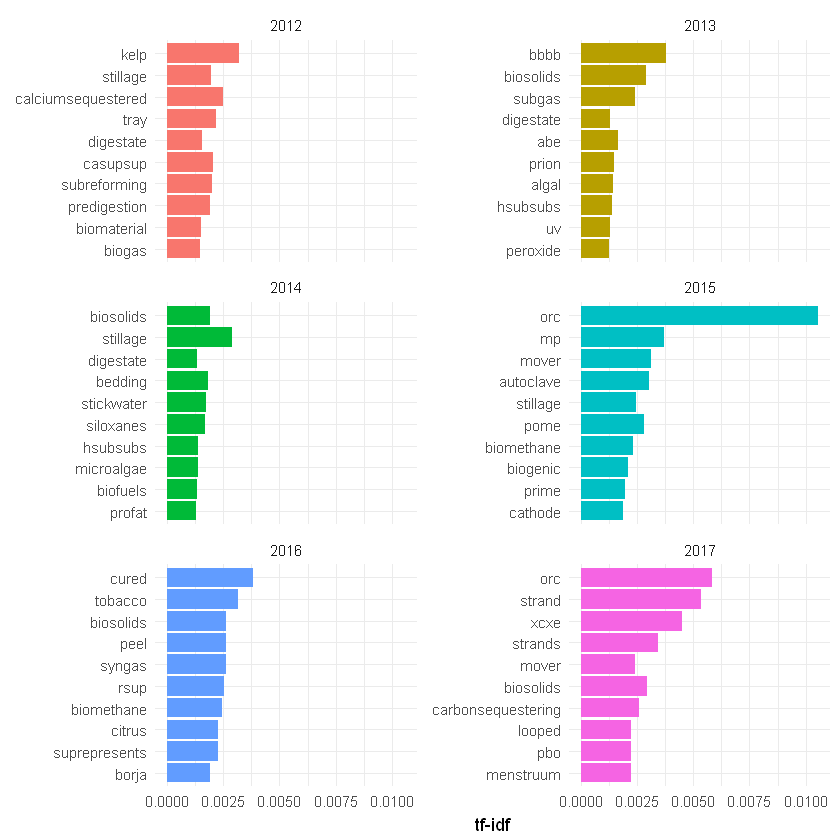

In [25]:
abstract_tf_idf %>% 
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(word, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free_y") +
  coord_flip()

### TF-IDF on bigrams

In [26]:
abstract_bigrams <- df_with_patent_id %>% 
  unnest_tokens(bigram, Abstract, token = "ngrams", n = 2)

abstract_bigrams %>% 
  count(bigram, sort = TRUE)

bigrams_separated <- abstract_bigrams %>% 
  separate(bigram, c("word1", "word2"), sep = " ")

bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% all_stops$word) %>%
  filter(!word2 %in% all_stops$word)

bigram_counts <- bigrams_filtered %>%
  count(word1, word2, sort = TRUE)

bigram,n
of the,25768
in the,12918
to the,8196
from the,6181
the present,4704
in a,4367
and the,4291
can be,4273
present invention,4264
the invention,4186


In [27]:
bigrams_Query_filtered <- bigrams_separated %>%
  filter(!word1 %in% all_stops$word) %>%
  filter(!word2 %in% all_stops$word)

bigrams_Query_filtered_counts <- bigrams_Query_filtered %>% 
  count(word1, word2, sort = TRUE)

bigrams_Query_filtered_counts

bigrams_united <- bigrams_Query_filtered %>%
  unite(bigram, word1, word2, sep = " ")

word1,word2,n
anaerobic,digestion,3571
carbon,dioxide,1886
waste,water,1425
organic,waste,1195
wastewater,treatment,1161
sewage,sludge,1058
activated,sludge,1025
organic,matter,913
solid,waste,899
anaerobic,digester,895


In [28]:
bigram_tf_idf <- bigrams_united %>%
  count(IssueDate, bigram) %>%
  bind_tf_idf(bigram, IssueDate, n) %>%
  arrange(desc(tf_idf))
bigram_tf_idf

IssueDate,bigram,n,tf,idf,tf_idf
1986,low rank,53,0.011767318,3.737670,0.04398235
1980,bactericidal solution,34,0.009898108,3.737670,0.03699586
1979,pressurised stream,24,0.009661836,3.737670,0.03611275
1986,rank coals,42,0.009325044,3.737670,0.03485394
1979,aqueous material,23,0.009259259,3.737670,0.03460805
1979,oxygenating gas,20,0.008051530,3.737670,0.03009396
1980,bacteriacontaining liquid,25,0.007278020,3.737670,0.02720284
1981,digestion modules,39,0.008910212,3.044522,0.02712734
1979,oxygenated stream,18,0.007246377,3.737670,0.02708456
1990,mixed basic,62,0.009875757,2.639057,0.02606269


Selecting by tf_idf


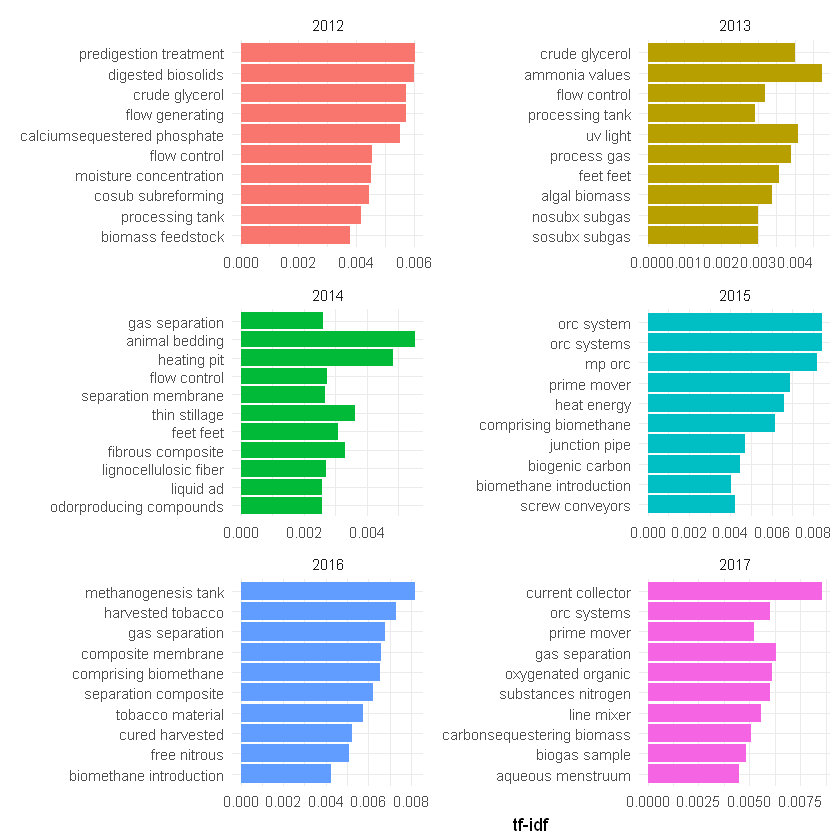

In [29]:
bigram_tf_idf %>%
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(bigram = factor(bigram, levels = rev(unique(bigram)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(bigram, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free") +
  coord_flip()

### TF-IDF on trigrams

In [30]:
abstract_trigrams <- df_with_patent_id %>%
  unnest_tokens(trigram, Abstract, token = "ngrams", n = 3)

In [31]:
abstract_trigrams %>%
    count(trigram, sort=TRUE)

trigram,n
the present invention,4250
of the invention,3024
of the present,2275
us pat no,2036
at least one,1231
portion of the,1187
the use of,1132
one or more,1089
to provide a,1019
object of the,968


In [32]:
trigrams_separated <- abstract_trigrams %>% 
    separate(trigram, c("word1","word2","word3", sep = " "))

Warning message:
"Too few values at 1826593 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ..."

In [33]:
trigrams_Query_filtered <- trigrams_separated %>% 
  filter(!word1 %in% all_stops$word) %>% 
  filter(!word2 %in% all_stops$word) %>%
  filter(!word3 %in% all_stops$word)

In [34]:
trigrams_Query_filtered_counts <- trigrams_Query_filtered %>% 
  count(word1, word2, word3, sort = TRUE)

In [35]:
trigrams_united <- trigrams_Query_filtered %>%
  unite(trigram, word1, word2, word3, sep = " ")

In [36]:
trigrams_tf_idf <- trigrams_united %>%
  count(IssueDate, trigram, sort =TRUE) %>%
  bind_tf_idf(trigram, IssueDate, n) %>%
  arrange(desc(tf_idf))

Selecting by tf_idf


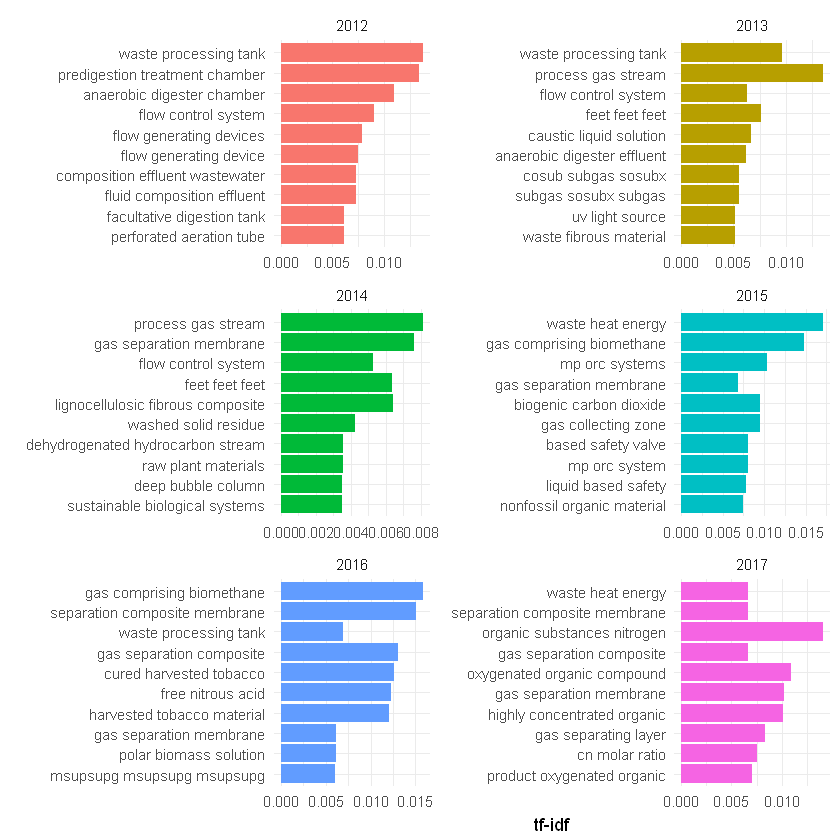

In [37]:
trigrams_tf_idf %>%
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(trigram = factor(trigram, levels = rev(unique(trigram)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(trigram, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free") +
  coord_flip()

### Visualizing bigram networks

In [38]:
bigram_graph <- bigrams_Query_filtered_counts %>%
  filter(n > 100) %>%
  graph_from_data_frame()

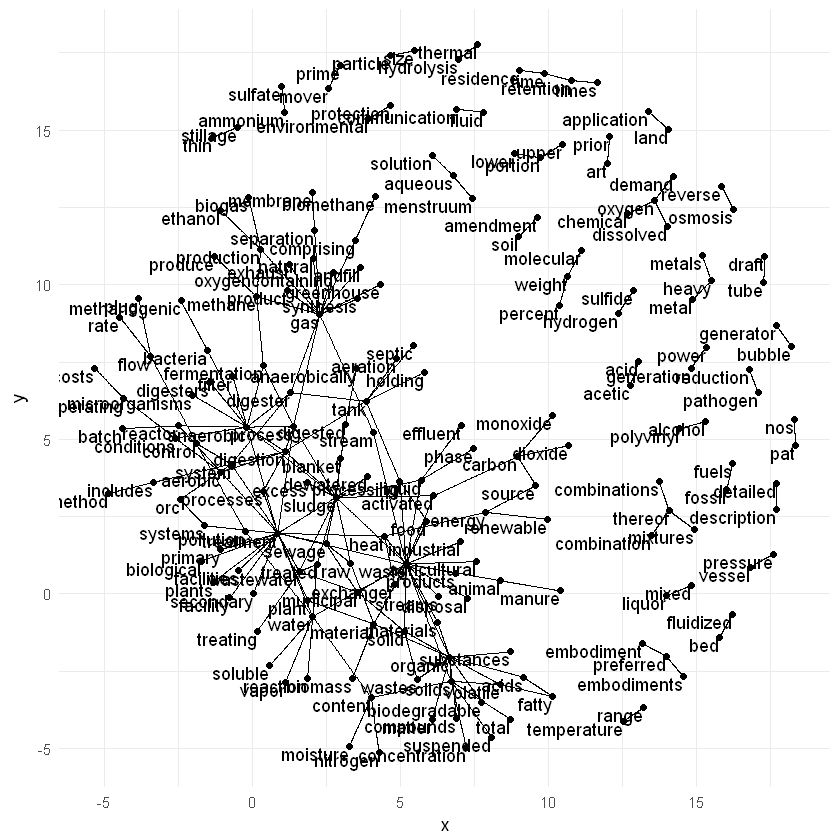

In [39]:
set.seed(2016)

ggraph(bigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

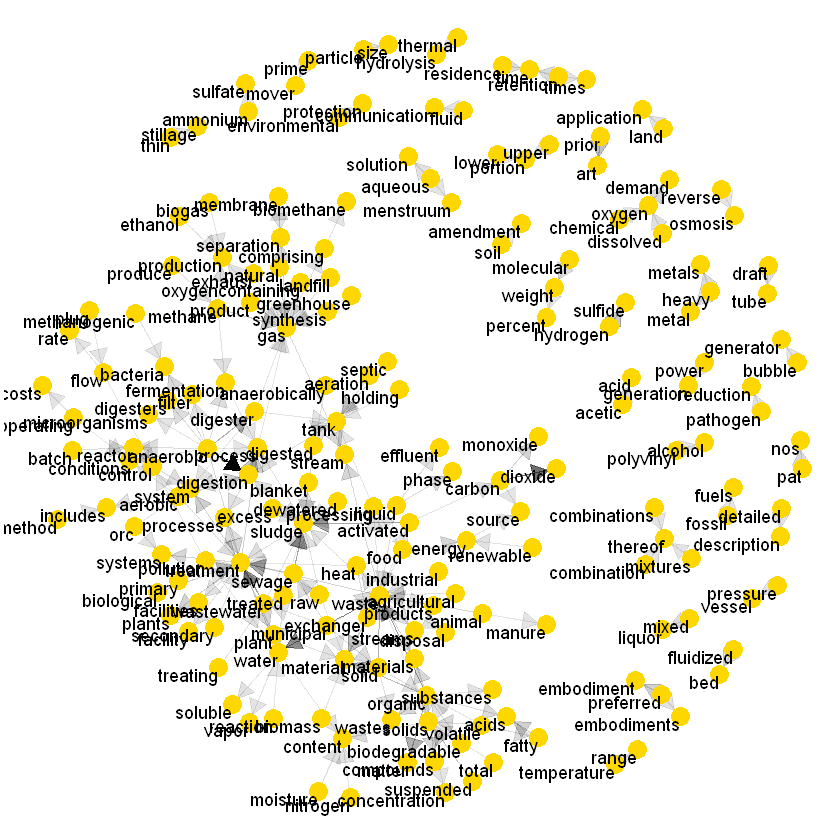

In [40]:
set.seed(2016)
a <- grid::arrow(type = "closed", length = unit(.15, "inches"))
ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "gold", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

In [41]:
trigram_graph <- trigrams_Query_filtered_counts %>%
  filter(n > 40) %>%
  graph_from_data_frame()

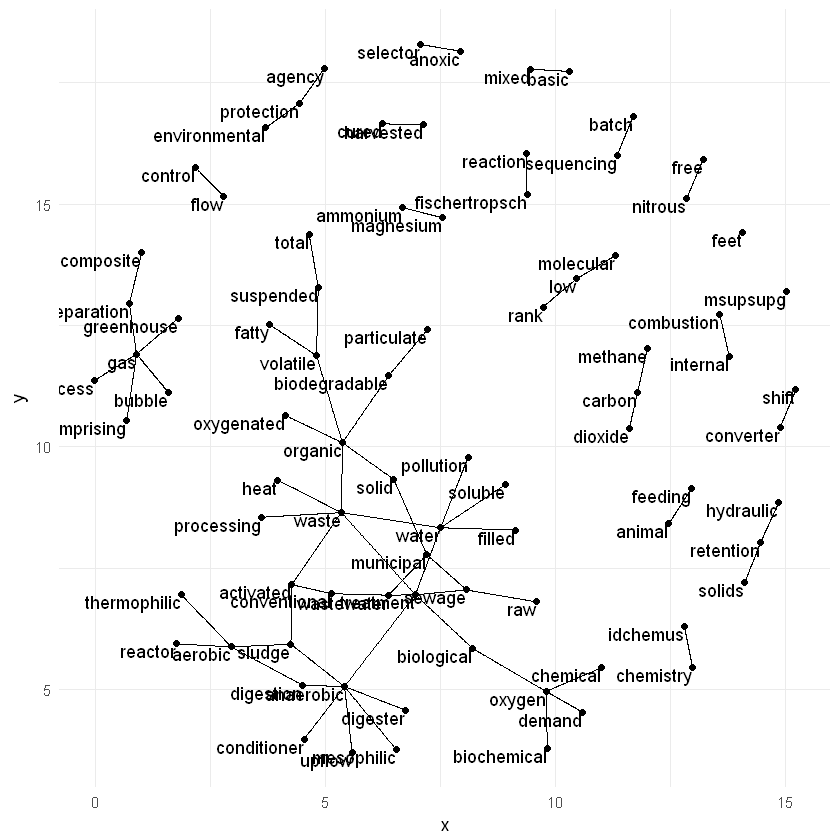

In [42]:
ggraph(trigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

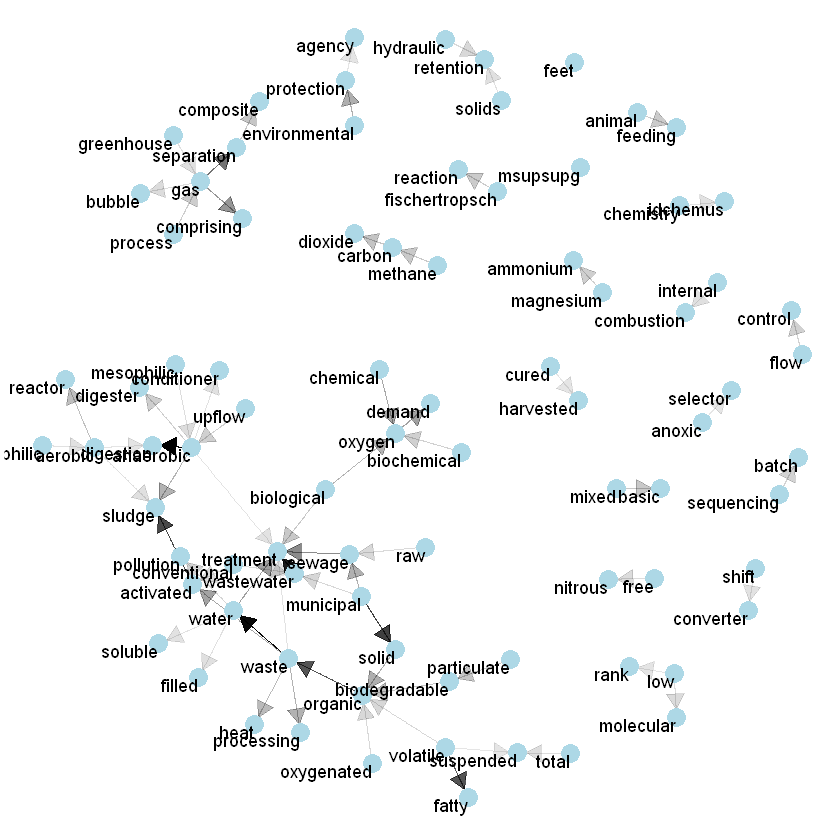

In [43]:
a <- grid::arrow(type = "closed", length = unit(.15, "inches"))
ggraph(trigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

### Word correlations

In [69]:
abstract_section_words <- df_with_patent_id %>%
  filter(IssueDate == "2016") %>%
  mutate(section = row_number() %/%4) %>%
  filter(section > 0) %>%
  unnest_tokens(word, Abstract) %>%
  filter(!word %in% all_stops$word)

In [70]:
word_pairs <- abstract_section_words %>%
  pairwise_count(word, section, sort = TRUE)

In [71]:
word_cors <- abstract_section_words %>%
  group_by(word) %>%
  filter(n() >= 50) %>%
  pairwise_cor(word, section, sort = TRUE)
word_cors

item1,item2,correlation
cured,tobacco,1
tobacco,cured,1
art,relates,1
introduction,relates,1
added,relates,1
pressure,cost,1
relates,art,1
introduction,art,1
added,art,1
typically,produce,1


Selecting by correlation


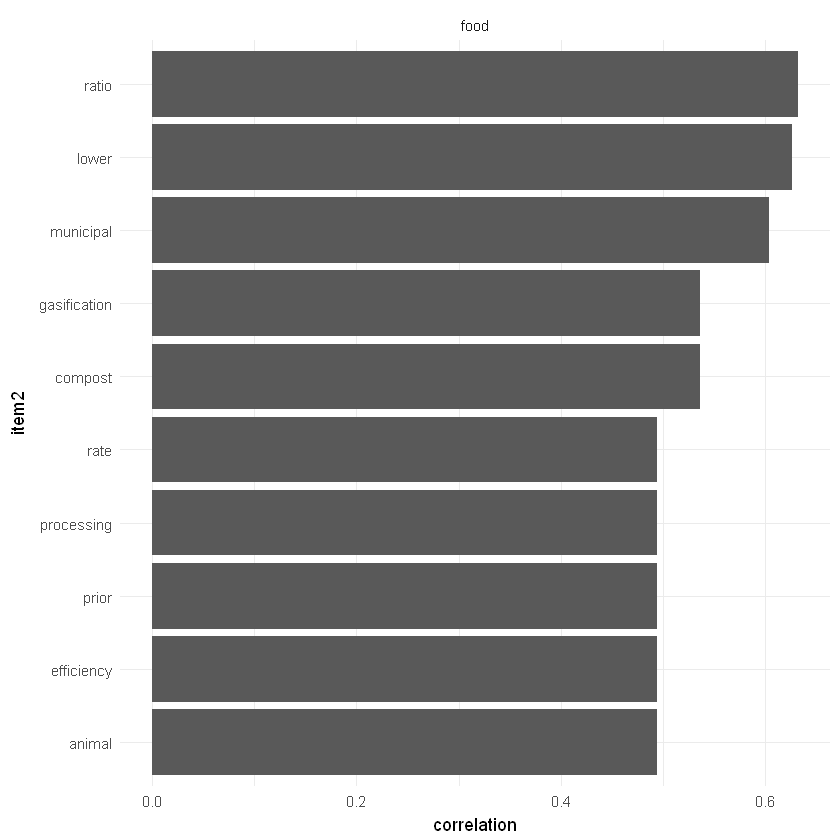

In [72]:
word_cors %>%
  filter(item1 %in% c("food", "digestion")) %>%
  group_by(item1) %>%
  top_n(7) %>%
  ungroup() %>%
  mutate(item2 = reorder(item2, correlation)) %>%
  ggplot(aes(item2, correlation)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ item1, scales = "free_x") +
  coord_flip()

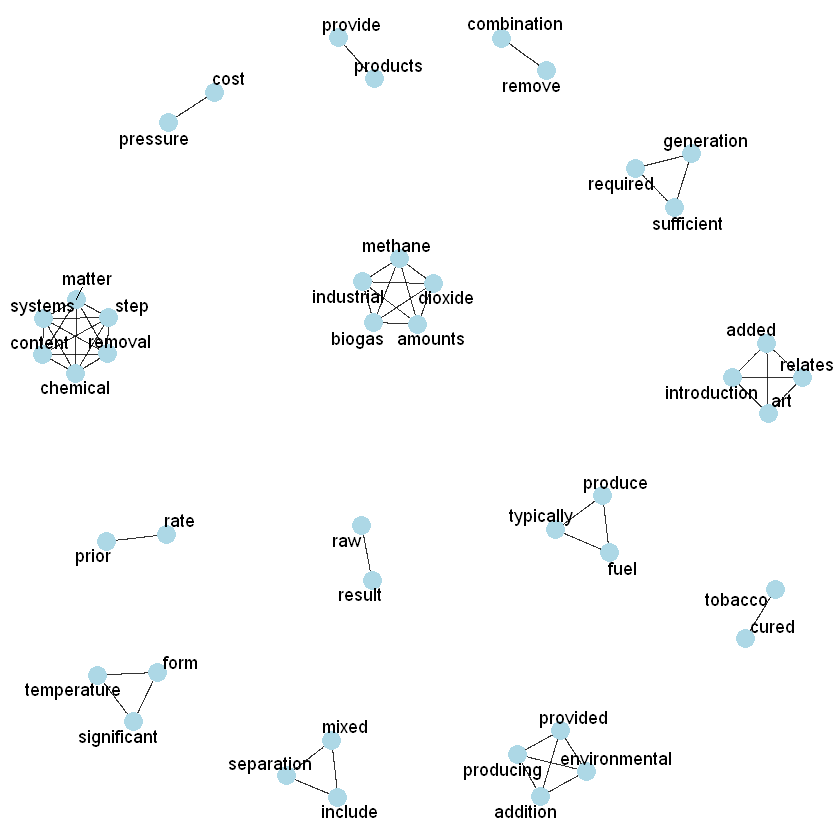

In [73]:
word_cors %>%
  filter(correlation > .94) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation), show.legend = FALSE) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), repel = TRUE) +
  theme_void()

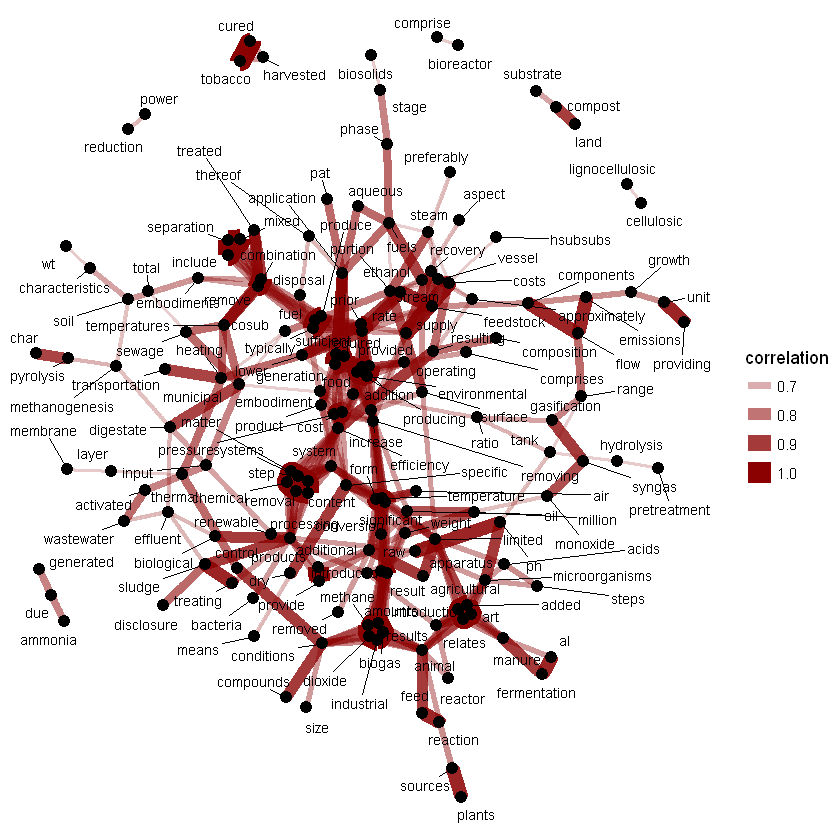

In [82]:
set.seed(1)
word_cors %>%
  filter(correlation > .60) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation, edge_width = correlation),
                 edge_colour = 'darkred',
                 show.legend = TRUE) +
  geom_node_point(size = 3) +
  geom_node_text(aes(label = name), repel = TRUE, size=3,
                 point.padding = unit(0.2, "lines")) +
  theme_void()

### Latent dirichlet analysis

In [74]:
#Load data
filename = "ad1.csv" # "fw1.csv" is our raw data which has been slightly pre-processed in Excel. 
df <- read.csv(filename)
df$text <- as.character(df$text)
df$IssueDate <- as.factor(df$IssueDate)

In [75]:
str(df)

'data.frame':	1026 obs. of  6 variables:
 $ PatentNo : Factor w/ 1026 levels "3931012","3933628",..: 802 414 476 406 920 383 921 816 815 191 ...
 $ title    : Factor w/ 901 levels " which is sent to the disrober with subsequent decomposition of the solution into CO<sub>2 </sub>and processing"| __truncated__,..: 392 438 382 851 582 722 268 622 798 354 ...
 $ abstract : Factor w/ 935 levels ""," A batch process for the conversion of organic solid waste material containing cellulose and lignin through liq"| __truncated__,..: 443 480 906 477 471 324 405 768 792 238 ...
 $ text     : chr  "FIELD OF THE PATENT APPLICATION The present patent application relates to a method and a system for treating do"| __truncated__ "BACKGROUND OF THE INVENTION The present invention relates generally to the field of waste management, and in pa"| __truncated__ "FIELD OF THE INVENTION The present invention relates to a process for utilizing waste waters which comprises th"| __truncated__ "BACKGROUND OF THE INV

In [76]:
#Remove common stop words
data("stop_words")

# Custom stop words
additional_stop_words <- data_frame(word=c("figref", "idrefdrawingsfig", "bb", "xb", "patent", "document", 
                                           "xbsubsub", "fig"， "invention"),
                                   lexicon = rep("custom"))

#Bind stop word data
all_stops <- bind_rows(stop_words, additional_stop_words)

In [77]:
#Define a function to clean our text
#Here we lemmatize words and remove punctiation, numbers, and stopwords. 
clean_patent <- function(df, column_name){
    #clean the text of a patent : put to lowercase, lemmatize, remove punctuation and numbers
    start.time <- Sys.time()
    cleaned_text <- df[,c(column_name)]%>%
        tolower() %>%
        lemmatize_strings() %>%
        removeWords(all_stops$word) %>%
        removeNumbers() %>%
        removePunctuation()
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    time.taken
    return(cleaned_text)  
}

In [78]:
df[,c("text")] <- clean_patent(df, "text")

In [79]:
#Define function to create a document-term matrix
create_document_matrix <- function(df){
    #create document matrix
    text_lda <- df %>%
        mutate(PatentNo = as.integer(PatentNo)) %>%
        as_tibble() %>%
        select_("text","PatentNo") %>% 
        unnest_tokens(word, text) %>%
        count(PatentNo, word) %>% 
        cast_dtm(PatentNo, word, n)
    text_lda
}

In [80]:
#Split the data between train and validation set : the validation set will be used to get the right number of topics
n <- nrow(df)
splitter <- sample(1:n, round(n * 0.7))
train_set <- df[splitter, ]
valid_set <- df[-splitter, ]

In [81]:
str(train_set)

'data.frame':	718 obs. of  6 variables:
 $ PatentNo : Factor w/ 1026 levels "3931012","3933628",..: 652 871 39 450 328 162 998 34 506 989 ...
 $ title    : Factor w/ 901 levels " which is sent to the disrober with subsequent decomposition of the solution into CO<sub>2 </sub>and processing"| __truncated__,..: 412 394 552 369 440 103 257 277 166 361 ...
 $ abstract : Factor w/ 935 levels ""," A batch process for the conversion of organic solid waste material containing cellulose and lignin through liq"| __truncated__,..: 787 852 75 426 322 203 398 310 630 893 ...
 $ text     : chr  "background      relate   modular process  strand gas  methane component   natural gas stream suitable  injectio"| __truncated__ "field     relate  water treatment specifically   disclose  method  optimize    levels  increase  specific growt"| __truncated__ " field      relate   organic digester      improve organic digester apparatus    improve method  produce liquid"| __truncated__ "technical field    relate

In [82]:
#Make a document term matrix for the training set and the validation set
lda_document_matrix_train <- create_document_matrix(train_set)
lda_document_matrix_valid <- create_document_matrix(valid_set)

In [83]:
#Function to create LDA model based on different topics
create_lda_model <- function(document_matrix, num_topics, seed=1234){
    #create lda model
    lda_model <- LDA(document_matrix, k=num_topics, control = list(seed=seed))
    lda_model
}

In [84]:
# Let's try out different values of K. CAREFUL, this takes a few hours to run. 
candidate_k <- c(2, 4, 8, 10, 20, 30) 
perplexities <- vector(mode="list", length=length(candidate_k))
names(perplexities) <- candidate_k
index <- 1
start.time <- Sys.time()
for(k in candidate_k){
    print(paste("k=",k,sep=""))
    lda_model <- create_lda_model(lda_document_matrix_train, k)
    perplexities[index] <- perplexity(lda_model, newdata = lda_document_matrix_valid)
    index <- index + 1
}
end.time <- Sys.time()
print(end.time - start.time)
print(perplexities)

[1] "k=2"
[1] "k=4"
[1] "k=8"
[1] "k=10"
[1] "k=20"
[1] "k=30"
Time difference of 33.76107 mins
$`2`
[1] 1170.588

$`4`
[1] 1078.715

$`8`
[1] 981.1491

$`10`
[1] 961.7748

$`20`
[1] 873.1747

$`30`
[1] 842.7001



In [85]:
# save(perplexities, file = "perplexities.rda")
#load("perplexities.rda")

In [86]:
Topics <- candidate_k
Perplexity <- c(perplexities[[1]],perplexities[[2]],perplexities[[3]],perplexities[[4]],perplexities[[5]],perplexities[[6]])

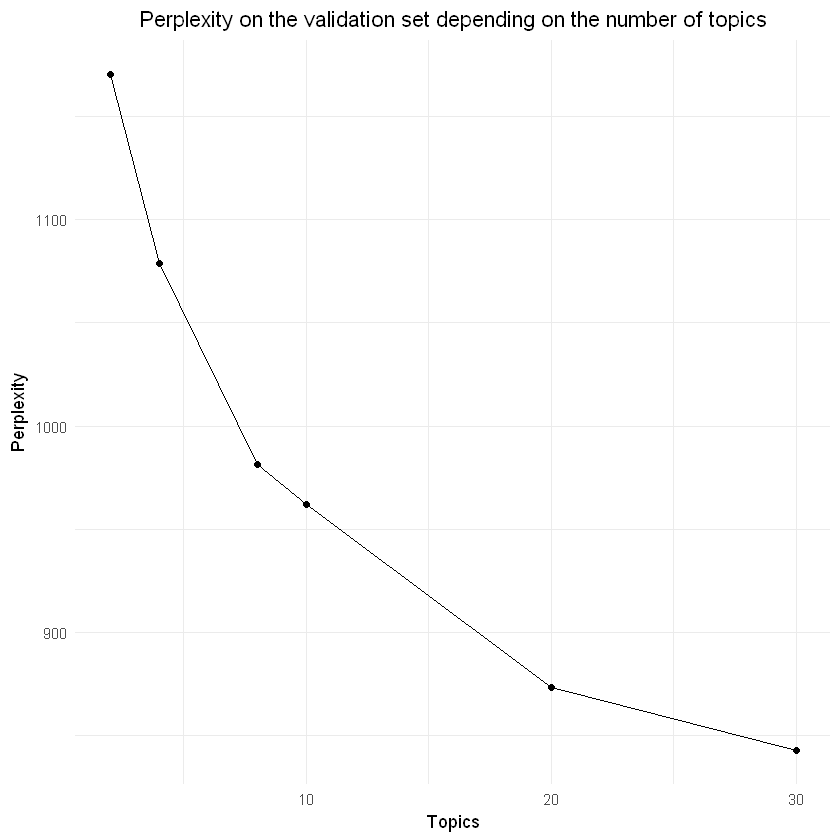

In [87]:
num_topics_vs_perplexity <- data.frame(Topics, Perplexity)
ggplot(num_topics_vs_perplexity, aes(Topics, Perplexity)) + 
    geom_line() + 
    geom_point() + 
    ggtitle("Perplexity on the validation set depending on the number of topics") +
    theme(plot.title = element_text(hjust = 0.5))

In [88]:
lda_df <- as_tibble(text_df)

In [89]:
abstract_lda <- lda_df %>% 
  unnest_tokens(word, text) %>% 
  anti_join(all_stops) %>% 
  count(line, word) %>% 
  cast_dtm(line, word, n)

Joining, by = "word"


In [90]:
abstract_lda

<<DocumentTermMatrix (documents: 1026, terms: 26876)>>
Non-/sparse entries: 369099/27205677
Sparsity           : 99%
Maximal term length: 58
Weighting          : term frequency (tf)

In [91]:
ap_lda <- LDA(abstract_lda, k=20, control = list(seed=1234))

In [92]:
ap_topics <- tidy(ap_lda, matrix = "beta")
ap_topics

topic,term,beta
1,abovementioned,1.205601e-04
2,abovementioned,1.621896e-04
3,abovementioned,3.604329e-04
4,abovementioned,1.049204e-04
5,abovementioned,1.569265e-05
6,abovementioned,1.126859e-24
7,abovementioned,5.119550e-05
8,abovementioned,1.562947e-04
9,abovementioned,5.145506e-05
10,abovementioned,5.835153e-05


In [93]:
ap_top_terms <- ap_topics %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

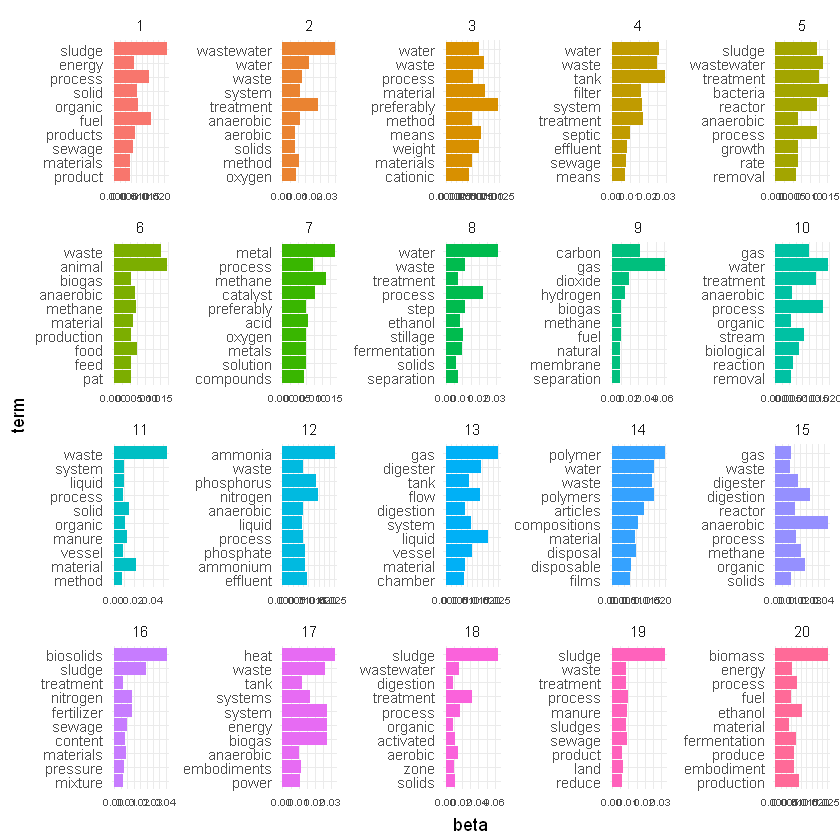

In [94]:
ap_top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  theme(axis.text.x=element_text(size=rel(0.7)))

In [95]:
#beta spread topics 1 and 2
beta_spread <- ap_topics %>%
  mutate(topic = paste0("topic", topic)) %>%
  spread(topic, beta) %>%
  filter(topic1 > .001 | topic2 > .001) %>%
  mutate(log_ratio = log2(topic2 / topic1))

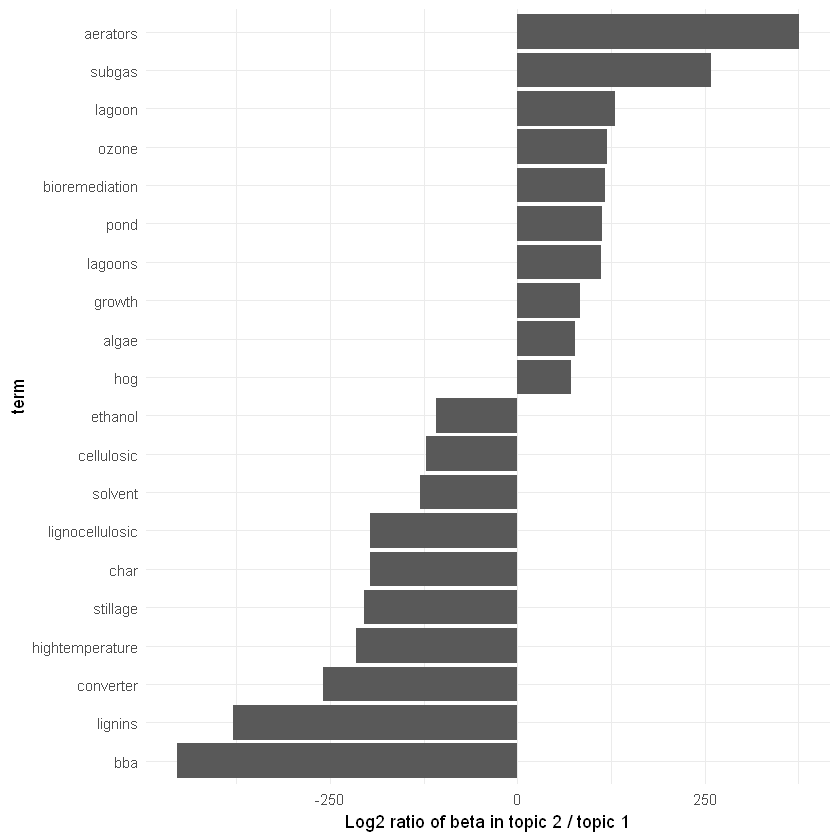

In [96]:
#beta spread topics 1 and 2 visualized
beta_spread %>%
  group_by(direction = log_ratio > 0) %>%
  top_n(10, abs(log_ratio)) %>%
  ungroup() %>%
  mutate(term = reorder(term, log_ratio)) %>%
  ggplot(aes(term, log_ratio)) +
  geom_col() +
  labs(y = "Log2 ratio of beta in topic 2 / topic 1") +
  coord_flip()